## Modified introduction using forex data

This is the trading rule example shown in [the introduction](https://github.com/robcarver17/pysystemtrade/blob/master/docs/introduction.md) but modified to use Interactive Brokers instead of CSV files as data source.  

IB requires a minimum equity and a monthly subscription to provide historical data on future contracts.  This example was modified to use FX prices instead futures to make it runnable with free unfunded paper trading accounts.  Note that Rob [does not recommend trading FX spot data with IB due to their high fees](https://github.com/robcarver17/pysystemtrade/issues/517#issuecomment-1010770678).

First, import the required packages and initialize ib_insync.  

In [1]:

import os
# set environment

from sysbrokers.IB.ib_connection import connectionIB
from sysbrokers.IB.ib_Fx_prices_data import ibFxPricesData
from sysdata.data_blob import dataBlob

from ib_insync import util
util.startLoop() #only required when running inside a notebook


Configuring sim logging
2024-06-23 23:06:22 DEBUG config {'type': 'config', 'stage': 'config'} Adding config defaults


IB broker connection{'ipaddress': '10.1.101.26', 'port': 7497, 'client': 111}

Connecting to Interactive Brokers gateway...

In [2]:
conn = connectionIB(111)
conn

IB broker connection{'ipaddress': '10.1.101.26', 'port': 7497, 'client': 111}

See what fx instruments we have configured.  These are configured in `sysbrokers/IB/ib_config_spot_FX.csv`

In [2]:
ibfxpricedata = ibFxPricesData(conn, dataBlob())
ibfxpricedata.get_list_of_fxcodes()

['AUDUSD',
 'CADUSD',
 'CHFUSD',
 'EURUSD',
 'GBPUSD',
 'HKDUSD',
 'JPYUSD',
 'KRWUSD',
 'CNHUSD',
 'SGDUSD',
 'MXPUSD',
 'SEKUSD']

Now we select one instrument (`EURUSD`) and try to fetch historical data for it.

In [5]:
ibfxpricedata.get_fx_prices('EURUSD')

2024-06-23 11:58:23 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Updating log attributes
2024-06-23 11:58:25 DEBUG ibFxPricesData Log attributes reset
2024-06-23 11:58:25 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Downloaded 259 prices


2024-06-23 11:58:25 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Reqid -1: 2106 HMDS data farm connection is OK:cashhmds for None


index
2023-06-23 23:00:00    1.089175
2023-06-26 23:00:00    1.090590
2023-06-27 23:00:00    1.096040
2023-06-28 23:00:00    1.091315
2023-06-29 23:00:00    1.086430
                         ...   
2024-06-17 23:00:00    1.073440
2024-06-18 23:00:00    1.073955
2024-06-19 23:00:00    1.074260
2024-06-20 23:00:00    1.070210
2024-06-21 23:00:00    1.069230
Name: FINAL, Length: 259, dtype: float64

Data can also be indexed as a python dict:

In [6]:
ibfxpricedata['JPYUSD']

2024-06-23 11:58:40 DEBUG ibFxPricesData {'currency_code': 'USDJPY'} Updating log attributes
2024-06-23 11:58:41 DEBUG ibFxPricesData Log attributes reset
2024-06-23 11:58:41 DEBUG ibFxPricesData {'currency_code': 'JPYUSD'} Downloaded 259 prices


index
2023-06-23 23:00:00    0.006960
2023-06-26 23:00:00    0.006969
2023-06-27 23:00:00    0.006941
2023-06-28 23:00:00    0.006921
2023-06-29 23:00:00    0.006908
                         ...   
2024-06-17 23:00:00    0.006340
2024-06-18 23:00:00    0.006335
2024-06-19 23:00:00    0.006325
2024-06-20 23:00:00    0.006293
2024-06-21 23:00:00    0.006257
Name: FINAL, Length: 259, dtype: float64

Create the trading rule

In [7]:
import pandas as pd
from sysquant.estimators.vol import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds Lfast, Lslow and vol_lookback

    """
    if Lslow is None:
        Lslow = 4 * Lfast

    ## We don't need to calculate the decay parameter, just use the span directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma

    vol = robust_vol_calc(price.diff())

    return raw_ewmac / vol

Run a forecast with the previous rule

In [8]:
price=ibfxpricedata['EURUSD']
ewmac=calc_ewmac_forecast(price, 32, 128)
ewmac.tail(5)

2024-06-23 11:58:56 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Updating log attributes
2024-06-23 11:58:57 DEBUG ibFxPricesData Log attributes reset
2024-06-23 11:58:57 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Downloaded 259 prices


index
2024-06-17 23:00:00   -0.189195
2024-06-18 23:00:00   -0.257418
2024-06-19 23:00:00   -0.320788
2024-06-20 23:00:00   -0.420359
2024-06-21 23:00:00   -0.537793
Name: FINAL, dtype: float64

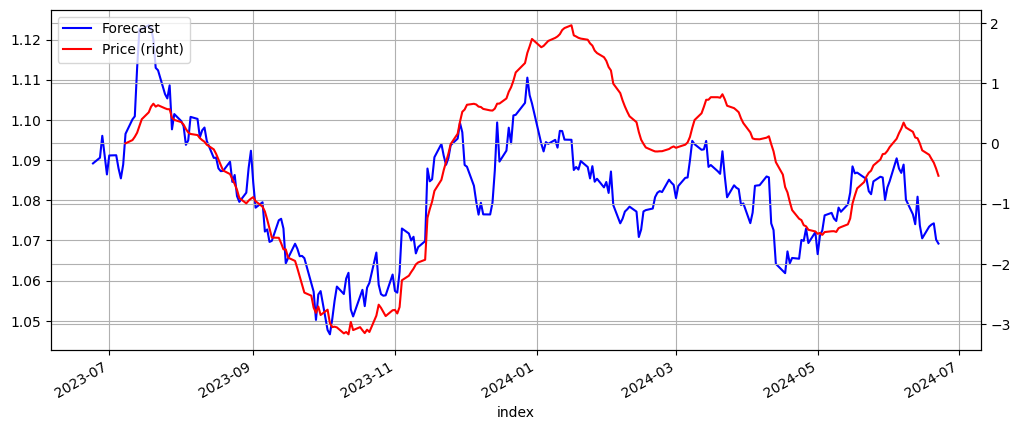

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

ax1 = price.plot(color='blue', grid=True, label='Forecast')
ax2 = ewmac.plot(color='red', grid=True, secondary_y=True, label='Price')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

The original introduction jumps directly to "Did we make any money?".  
I would like to see here the orders that were triggered by this forecast, but instead we jump directly into P&L.  Still, these are the P&L numbers for this forecast and data:

In [10]:
from systems.accounts.account_forecast import pandl_for_instrument_forecast
account = pandl_for_instrument_forecast(forecast = ewmac, price = price)
account.percent.stats()

[[('min', '-0.7908'),
  ('max', '0.6502'),
  ('median', '-0.0004399'),
  ('mean', '-0.011'),
  ('std', '0.1436'),
  ('skew', '-0.3331'),
  ('ann_mean', '-2.817'),
  ('ann_std', '2.297'),
  ('sharpe', '-1.226'),
  ('sortino', '-1.408'),
  ('avg_drawdown', '-2.081'),
  ('time_in_drawdown', '0.9119'),
  ('calmar', '-0.6463'),
  ('avg_return_to_drawdown', '-1.354'),
  ('avg_loss', '-0.08367'),
  ('avg_gain', '0.07958'),
  ('gaintolossratio', '0.9511'),
  ('profitfactor', '0.7513'),
  ('hitrate', '0.4413'),
  ('t_stat', '-1.238'),
  ('p_value', '0.2168')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

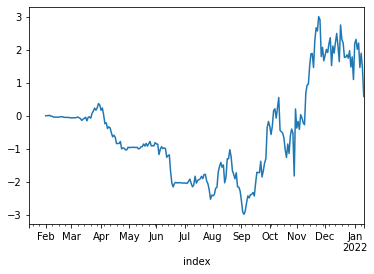

In [25]:
account.curve().plot()
plt.show()

In [11]:
conn.close_connection()

2024-06-23 11:59:28 DEBUG connectionIB {'type': 'connectionIB', 'broker': 'IB', 'clientid': 111} Terminating {'ipaddress': '10.1.101.26', 'port': 7497, 'client': 111}
